### 텐서플로와 다른 라이브러리 불러오기

In [1]:
# GIF를 만들기위해 설치합니다.
!pip install -q imageio

In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import pandas as pd
from keras.utils.np_utils import to_categorical
import random
import base64
from IPython.display import HTML
import time; import random; import datetime

from IPython import display

### 데이터셋 로딩 및 준비
생성자와 감별자를 훈련하기위해 MNIST 데이터셋을 사용할것입니다. 생성자는 손글씨 숫자 데이터를 닮은 숫자들을 생성할 것입니다. 

In [3]:
DFtrain = pd.read_csv('../input/computer-vision-learning-contest-dacon/train.csv')
test = pd.read_csv('../input/computer-vision-learning-contest-dacon/test.csv')
submission = pd.read_csv('../input/computer-vision-learning-contest-dacon/submission.csv')

In [4]:
X_train = (DFtrain[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)
y_train = to_categorical(DFtrain['digit'].values)

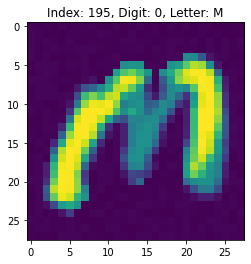

In [5]:
idx = random.randint(0, 2048)
img = DFtrain.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = DFtrain.loc[idx, 'digit']
letter = DFtrain.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

In [6]:
DFtrain[DFtrain.digit == 0]

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
15,16,0,I,1,3,2,3,0,2,4,...,0,2,3,3,2,4,2,3,1,4
21,22,0,Y,4,2,4,0,0,1,4,...,4,0,4,4,3,4,2,3,2,0
22,23,0,T,2,2,2,4,2,0,3,...,2,4,0,3,0,1,2,2,2,3
28,29,0,H,3,3,0,2,4,0,4,...,4,4,4,3,2,3,2,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,1991,0,D,2,2,3,2,4,0,2,...,0,4,0,0,1,4,1,0,2,3
1997,1998,0,Q,4,1,0,1,0,0,1,...,2,1,4,2,0,4,0,3,3,2
2019,2020,0,N,2,4,1,1,0,0,1,...,3,2,1,0,0,3,4,4,2,0
2033,2034,0,D,2,3,3,2,0,2,2,...,0,4,0,0,0,2,3,4,2,2


In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 32

In [8]:
# 데이터 배치를 만들고 섞습니다.
def CreatDataSet(X_train):
    train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return train_dataset

### 생성자

생성자는 시드값 (seed; 랜덤한 잡음)으로부터 이미지를 생성하기 위해, `tf.keras.layers.Conv2DTranspose` (업샘플링) 층을 이용합니다. 처음 `Dense`층은 이 시드값을 인풋으로 받습니다. 그 다음 원하는 사이즈 28x28x1의 이미지가 나오도록 업샘플링을 여러번 합니다. tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 `tf.keras.layers.LeakyReLU`을 사용하고 있음을 주목합시다.

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

(아직 훈련이 되지않은) 생성자를 이용해 이미지를 생성해봅시다. 

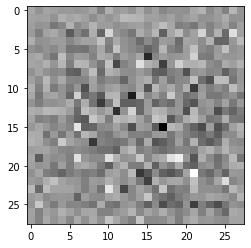

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### 감별자 
감별자는 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기입니다. 

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

(아직까지 훈련이 되지 않은) 감별자를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별합니다. 모델은 진짜 이미지에는 양수의 값 (positive values)을, 가짜 이미지에는 음수의 값 (negative values)을 출력하도록 훈련되어집니다.

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.002069]], shape=(1, 1), dtype=float32)


## 손실함수와 옵티마이저 정의
두 모델의 손실함수와 옵티마이저를 정의합니다. 

In [13]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 감별자 손실함수

이 메서드는 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화합니다. 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교합니다.

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 생성자 손실함수

생성자의 손실함수는 감별자를 얼마나 잘 속였는지에 대해 수치화를 합니다. 직관적으로 생성자가 원활히 수행되고 있다면, 감별자는 가짜 이미지를 진짜 (또는 1)로 분류를 할 것입니다. 여기서 우리는 생성된 이미지에 대한 감별자의 결정을 1로 이루어진 행렬과 비교를 할 것입니다. 

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

감별자와 생성자는 따로 훈련되기 때문에, 감별자와 생성자의 옵티마이저는 다릅니다.

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 체크포인트 저장
이 노트북은 오랫동안 진행되는 훈련이 방해되는 경우에 유용하게 쓰일 수 있는 모델의 저장방법과 복구방법을 보여줍니다. 

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 훈련 루프 정의하기

In [23]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

훈련 루프는 생성자가 입력으로 랜덤시드를 받는 것으로부터 시작됩니다. 그 시드값을 사용하여 이미지를 생성합니다. 감별자를 사용하여 (훈련 세트에서 갖고온) 진짜 이미지와 (생성자가 생성해낸) 가짜이미지를 분류합니다. 각 모델의 손실을 계산하고, 그래디언트 (gradients)를 사용해 생성자와 감별자를 업데이트합니다.

In [19]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs, numValue):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             numValue)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Num {} time for epoch {} is {} sec'.format(numValue, epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed,
                           numValue)

**이미지 생성 및 저장**


In [21]:
def generate_and_save_images(model, epoch, test_input, k):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('NUM{}_image_at_epoch_{:04d}.png'.format(k, epoch))
  plt.show()

## 모델 훈련
위에 정의된 `train()` 메서드를 생성자와 감별자를 동시에 훈련하기 위해 호출합니다. 생성적 적대 신경망을 학습하는 것은 매우 까다로울 수 있습니다. 생성자와 감별자가 서로를 제압하지 않는 것이 중요합니다. (예를 들어 학습률이 비슷하면 한쪽이 우세해집니다.)
훈련 초반부에는 생성된 이미지는 랜덤한 노이즈처럼 보입니다. 훈련이 진행될수록, 생성된 숫자는 점차 진짜처럼 보일 것입니다. 약 50 에포크가 지난 후, MNIST 숫자와 닮은 이미지가 생성됩니다. 코랩에서 기본 설정으로 실행하면, 에포크마다 1분정도 소요될 것입니다.

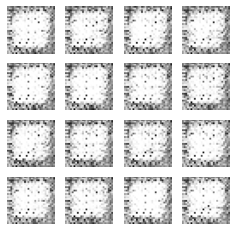

In [24]:
weight_dir = './weight/'
weight_prefix = os.path.join(checkpoint_dir, "ckpt")

for i in range(0, 10):
#     %%time
    train(CreatDataSet(np.array(DFtrain[DFtrain.digit == i].drop(['id', 'digit', 'letter'], axis=1, inplace=False)).reshape(-1, 28, 28, 1)), EPOCHS, i)

#     discriminator.save(f'./weight/NUM-{i}-Params.h5')
    
    discriminator.save(f'NUM-{i}-Params.h5')
    
    model_json = discriminator.to_json()
    with open(f"NUM{i}.json", "w") as json_file : 
        json_file.write(model_json)

마지막 체크포인트를 복구합니다.

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## GIF 생성

In [26]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no, num):
  return PIL.Image.open('NUM{}_image_at_epoch_{:04d}.png'.format(num, epoch_no))

In [27]:
for i in range (0, 10):
    display_image(EPOCHS, i)

`imageio`로 훈련 중에 저장된 이미지를 사용해 GIF 애니메이션을 만듭니다.

In [28]:
anim_file = 'dcgan.gif'

for i in range(0, 10):
    with imageio.get_writer(f'NUM-{i}-dcgan.gif', mode='I') as writer:
      filenames = glob.glob('NUM{}_image_at_epoch_{:04d}.png'.format(i, i))
      filenames = sorted(filenames)
      last = -1
      for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
          last = frame
        else:
          continue
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

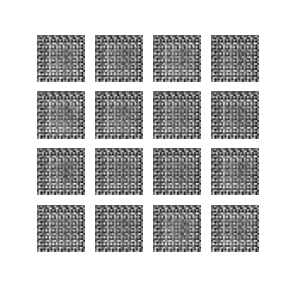

In [29]:
import IPython
# for i in range(0, 10):
display.Image(filename=f'NUM-{1}-dcgan.gif')

코랩에서 작업하고 있다면, 아래의 코드에서 애니메이션을 다운로드 받을 수 있습니다: 

In [30]:
now = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')

In [31]:
# make_discriminator_model(img)

discriminator = make_discriminator_model()
decision = discriminator(img.reshape(1, 28, 28, 1))
print(decision)

tf.Tensor([[-9.142638]], shape=(1, 1), dtype=float32)


In [45]:
Ans = []
for i in range(0, 10):
    new_model = tf.keras.models.load_model(f'./NUM-{i}-Params.h5')
    
    decision = new_model(img.reshape(1, 28, 28, 1))
    Ans.append(decision)
    

# MAXSoftMaxEnsemble = tf.math.argmax(
#     np.array(tf.nn.softmax(np.array(Ans).reshape(-1, 10), axis=None, name=None),), axis=1, output_type=tf.dtypes.int64, name=None
#     )
# MAXSoftMaxEnsemble

np.array(Ans).reshape(10,)
# np.array(tf.nn.softmax(np.array(Ans).reshape(10), axis=None, name=None),)
# np.array(tf.nn.softmax(np.array(Ans).reshape(-1, 10), axis=None, name=None)).shape

ResourceExhaustedError: OOM when allocating tensor with shape[5,5,64,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

# Todo

1. 숫자별 DCGAN 만들기
2. 숫자별 예측하기
3. 기존 CNN 모델과 앙상블 하기
4. Random한 곳들에 seed 넣기
5. 감별자 model 바꾸기